# Przemysław Kaleta
Data: https://data.stanford.edu/hcmst2017

Interesting link:
https://qz.com/quartzy/1551272/here-is-the-probability-you-will-break-up-with-your-partner/

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import xgboost as xgb

from collections import defaultdict

In [2]:
data = pd.read_stata("hcmts.dta")

Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q26_2** Did you and [Partner name] attend the same college or university?
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

In [3]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]

## Model fitting

In [4]:
# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

# usage: name_from_code["column_name"](code)
# If column name is not in binary variables name_from_code["column_name"] is an identity function.

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes

In [5]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true == 0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    
test_classifier(y_test, y_pred)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8076923076923077
F1 score: 0.7283702213279677


## Ceteris Paribus profile and Partial Dependency Plot

Let's try to make some plots showing how model prediction would change for different values of last two variables ("w6_q9" - partner age and "w6_q24_length" length of answer to the "how met" question) all other variables being the same.

In [6]:
random.seed(123)
random_person = X_test.iloc[random.choice(range(0, len(X_test)))]

In [7]:
def ceteris_paribus_plot(data, model, person, colname):
    
    def get_proba(person, colname, colvalue):
        new_person = pd.DataFrame([person.values], columns=data.columns[:-1])
        if colname not in X_train.columns:
            raise Exception("Wrong column name")
        new_person[colname] = colvalue
        return model.predict_proba(new_person)[0][0]
    
    min_value = np.quantile(data[colname].dropna(), 0.01, interpolation="higher")
    max_value = np.quantile(data[colname].dropna(), 0.99, interpolation="lower")
    values = np.linspace(min_value, max_value, 100)
    
    probas = [get_proba(person, colname, value) for value in values]
    
    plt.plot(values, probas)
    plt.plot(person[colname], get_proba(person, colname, person[colname]), "go")
    plt.title("Ceteris paribus profile")
    plt.xlabel(colname)
    plt.ylabel("Marriage probability")
    plt.show()

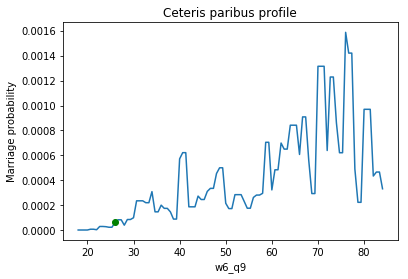

In [8]:
ceteris_paribus_plot(mydata, xgb_model, random_person, "w6_q9")

Now we will plot Partial dependency plot: average Ceteris Paribus profile for our population.

In [9]:
def partial_dependency_plot(data, model, colname, k=10):
    """Plots average Ceteris Paribus profile for sample population (k observations) from data"""
    
    def get_proba(person, colname, colvalue):
        new_person = pd.DataFrame([person.values], columns=data.columns[:-1])
        if colname not in X_train.columns:
            raise Exception("Wrong column name")
        new_person[colname] = colvalue
        return xgb_model.predict_proba(new_person)[0][0]
    

    min_value = np.quantile(data[colname].dropna(), 0.01, interpolation="higher")
    max_value = np.quantile(data[colname].dropna(), 0.99, interpolation="lower")
    values = np.linspace(min_value, max_value, 100)
    
    probas_list = [[get_proba(person, colname, value) for value in values] 
                   for _, person in data.drop("S1", axis=1).sample(k).iterrows()]
    mean_probas = [np.mean(values) for values in zip(*probas_list)]
    
    plt.plot(values, mean_probas)
    plt.title("Partial dependency plot")
    plt.xlabel(colname)
    plt.ylabel("Marriage probability")
    plt.show()

We see that results for a random person above are similar to general trend.

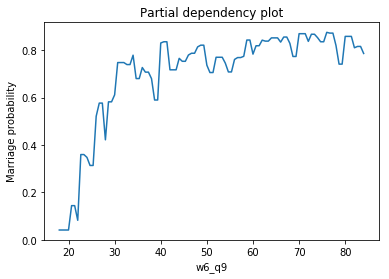

In [10]:
partial_dependency_plot(mydata, xgb_model, "w6_q9", k=10)

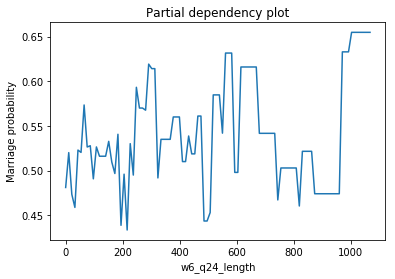

In [11]:
partial_dependency_plot(mydata, xgb_model, "w6_q24_length", k=10)

# Accumulated Local Effects Plot

In [12]:
def ale_plot(data, model, colname, window_size=5, take_every=5):
    """Plots Accumulated Local Effects (ALE) plot for given data, model and column"""
    
    def get_proba(person, colname):
        new_person = pd.DataFrame([person.values], columns=data.columns[:-1])
        return xgb_model.predict_proba(new_person)[0][0]
    
    data_sorted = data.loc[data[colname].notna()].sort_values(colname, ascending=True)
    n_observations = len(data_sorted)
    probas_list = [get_proba(person, colname)
                   for _, person in data_sorted.drop("S1", axis=1).iterrows()]
    
    values = []
    local_mean_differences = []
    for i in range(window_size, n_observations-window_size-1, take_every):
        value = data_sorted.iloc[i, :][colname]
        local_mean_difference = np.mean(np.ediff1d(probas_list[(i-window_size):(i+window_size+1)]))
        values.append(value)
        local_mean_differences.append(local_mean_difference)
    local_mean_differences = np.array(local_mean_differences) - np.mean(local_mean_differences)

    plt.plot(values, np.cumsum(local_mean_differences))
    plt.title(f"ALE plot for variable {colname}")
    plt.xlabel(colname)
    plt.show()

The main reason two use ALE instead of Partial Dependency Plot is having highly correlated features, which didn't occur in this case. It looks like ALE plot is similar to PD plot.

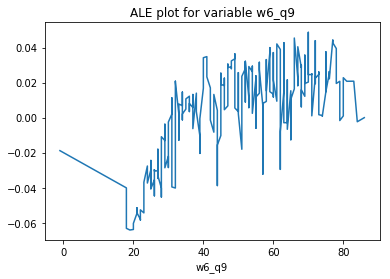

In [17]:
ale_plot(mydata, xgb_model, "w6_q9", take_every=10, window_size=20)

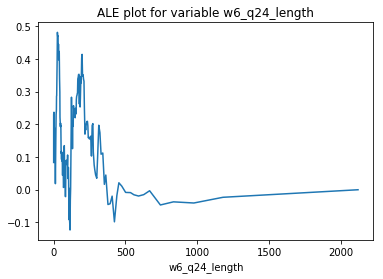

In [14]:
ale_plot(mydata, xgb_model, "w6_q24_length", take_every=20, window_size=5)

In [15]:
mydata.loc[:, ["w6_q9", "w6_q24_length"]].corr()

,w6_q9,w6_q24_length
w6_q9,1.000000,0.069457
w6_q24_length,0.069457,1.000000
